In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
from ema_workbench import load_results
from ema_workbench.analysis import prim

In [3]:
path = '../results/'
file_name = '2000_scen__AGGD_reps__0612__with_clusters'
file_ext  = '.tar.gz'

In [4]:
sns.set_style('whitegrid')

### Set-up

In [5]:
results = load_results(path + file_name + file_ext)
experiments, outcomes = results

In [6]:
# cluster_vars = [col for col in experiments if col[:7] == 'Cluster']
cluster_vars = [col for col in experiments if col[:12] == 'Cluster (VAR']
cluster_vars.extend([col for col in experiments if col[:12] == 'Cluster (MEA'])
cluster_vars

['Cluster (VAR(Household Population))',
 'Cluster (VAR(GDP))',
 'Cluster (VAR(Gini Coefficient))',
 'Cluster (MEAN(Household Population))',
 'Cluster (MEAN(GDP))',
 'Cluster (MEAN(Gini Coefficient))']

In [15]:
for var in cluster_vars:
    experiments[var] = experiments[var].astype('int32')

### Visual analysis

In [8]:
# cluster_var_of_interest = 'Cluster (Household Population)'
cluster_var_of_interest = 'Cluster (VAR(Household Population))'


Text(0.5, 1.0, 'Pairplot of model input parameters coloured by Cluster (VAR(Household Population))')

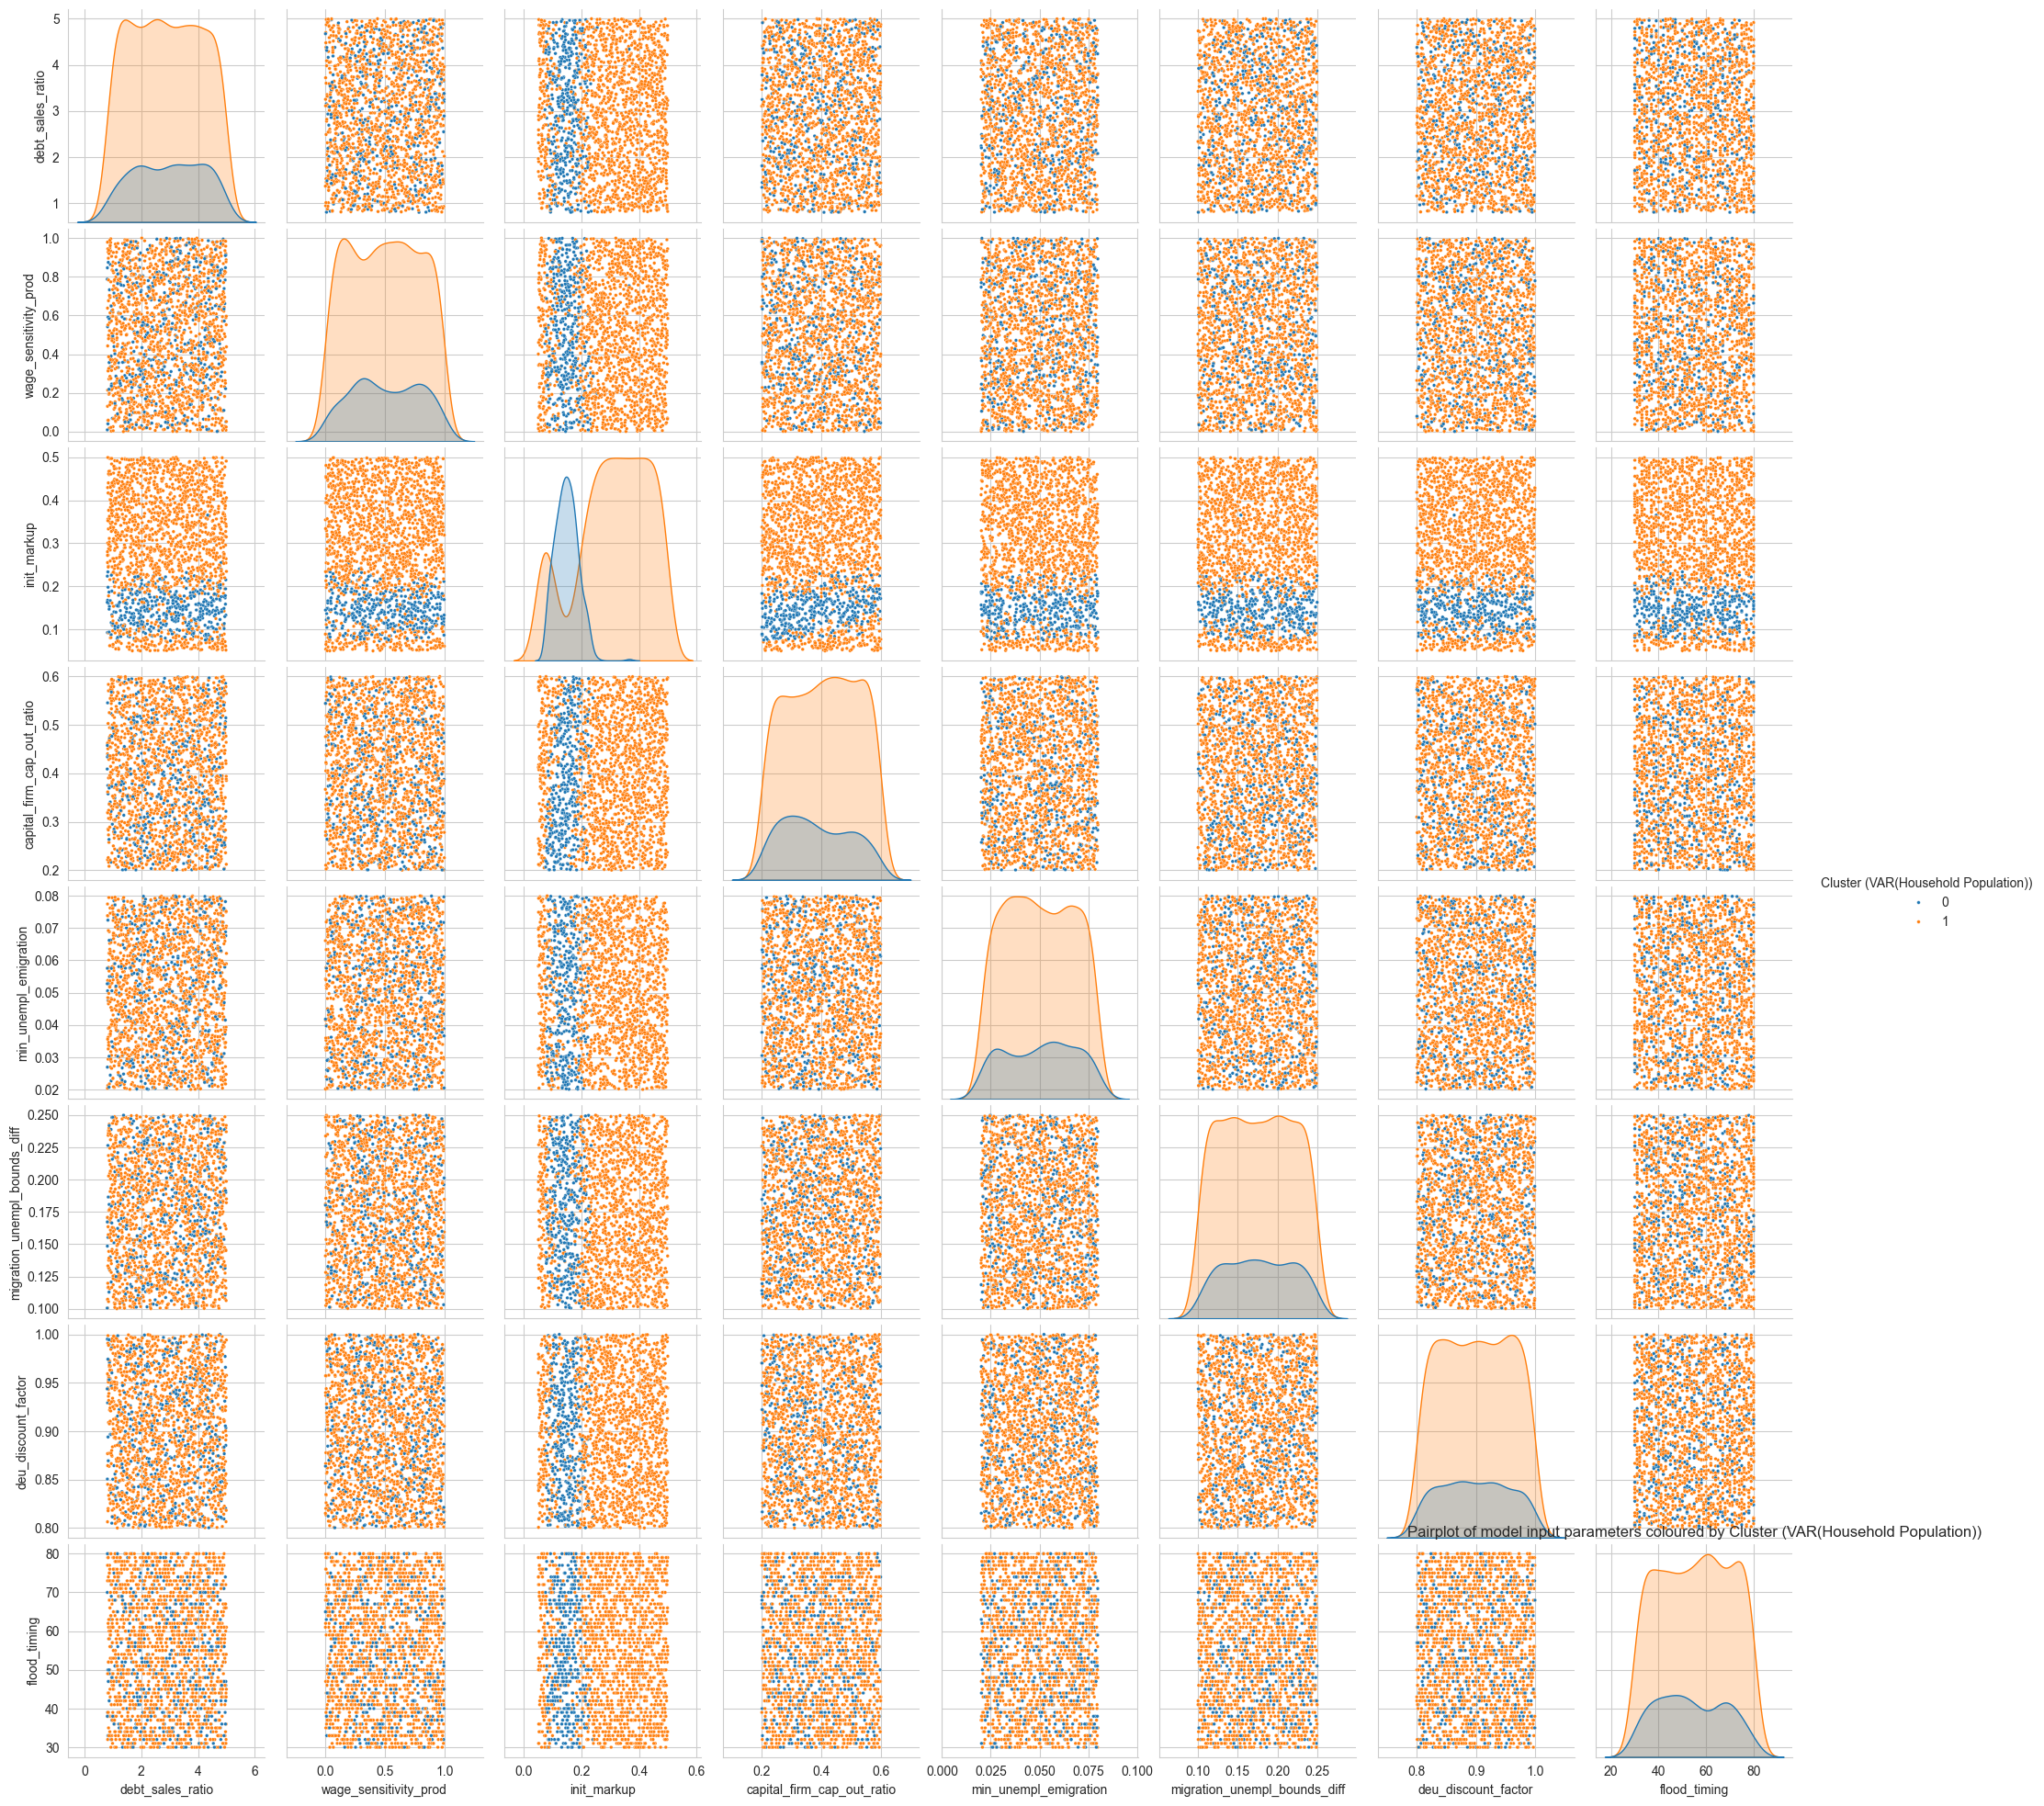

In [21]:
sns.pairplot(
    experiments,
    hue=cluster_var_of_interest,
    vars=[
        "debt_sales_ratio",
        "wage_sensitivity_prod",
        "init_markup",
        "capital_firm_cap_out_ratio",
        "min_unempl_emigration",
        "migration_unempl_bounds_diff",
        "deu_discount_factor",
        "flood_timing",
    ],
    plot_kws=dict(s=7),
    # palette={
    #     0 : '#00ff',
    #     1 : '#ff00',
    #     2 : '#0f0f',
    #     3 : '#f00f',
    #     4 : '#f0ff',
    # }
)
# plt.title(f'Pairplot of model input parameters coloured by {cluster_var_of_interest}')
plt.show()

(Written for the 10k scenario, no seeds run): We can already tell that init_markup seems to be the only input parameter that is associated with the clustering outputs. cap_out_ratio and min_unempl_emigration seem to have minor effects, the former being somewhat predictive of Cluster 3.

In [11]:
cols_to_ignore = ['scenario', 'policy', 'model'] 
for col in experiments.columns: 
    if 'Cluster' in col:
        cols_to_ignore.append(col)

experiments_prim = experiments[[c for c in experiments.columns if c not in cols_to_ignore]]
experiments_prim.columns

Index(['debt_sales_ratio', 'wage_sensitivity_prod', 'init_markup',
       'capital_firm_cap_out_ratio', 'min_unempl_emigration',
       'migration_unempl_bounds_diff', 'deu_discount_factor', 'flood_timing'],
      dtype='object')

### PRIM for Rule Induction

In [12]:
density_threshold = 0.75

In [20]:
# Find a set of boxes for each
prim_boxes = {}
for var in cluster_vars:
    n_clusters = experiments[var].max() + 1
    for cluster in range(n_clusters):
        prim_alg = prim.Prim(experiments_prim,
                             experiments[var] == cluster,
                             threshold=density_threshold)
        prim_boxes[(var, cluster)] = prim_alg.find_box()

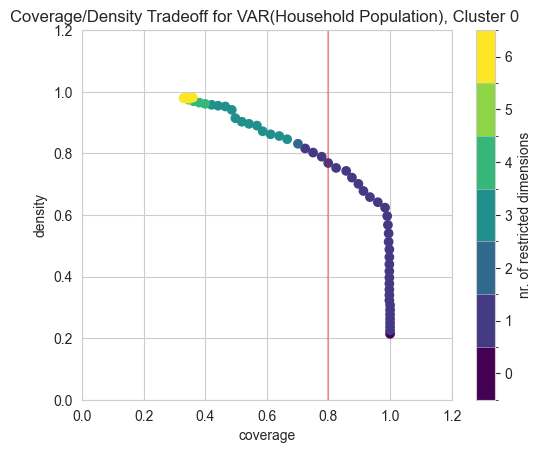

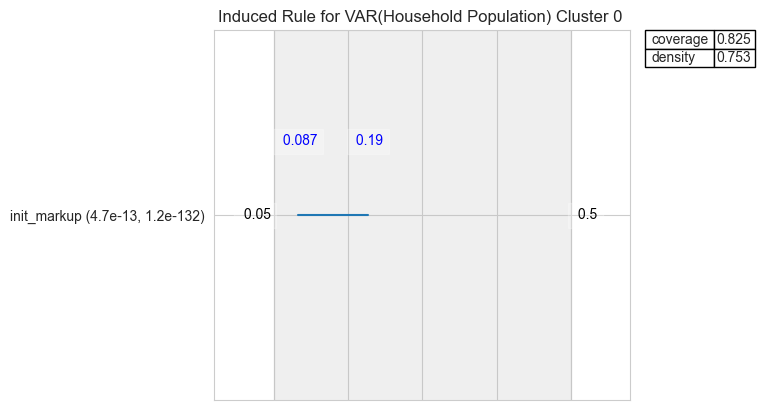

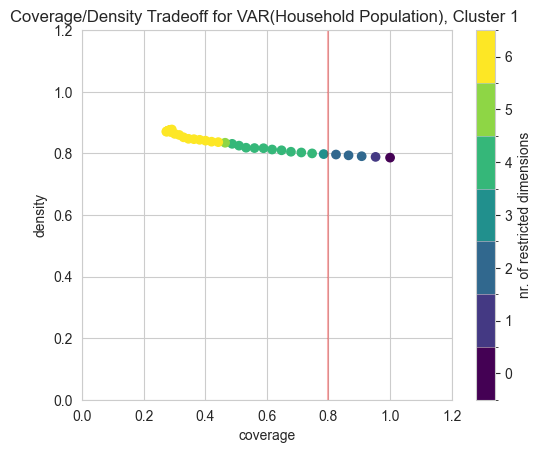

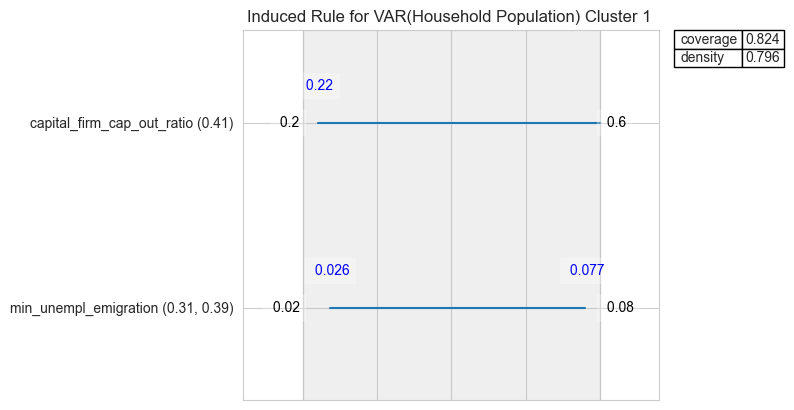

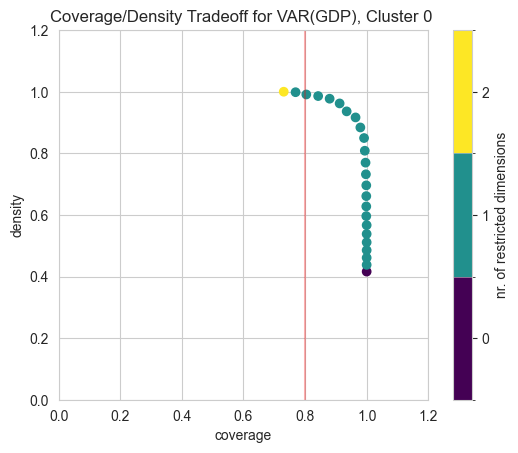

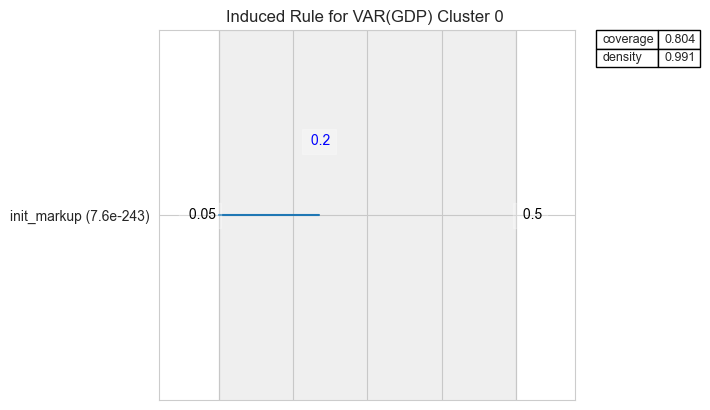

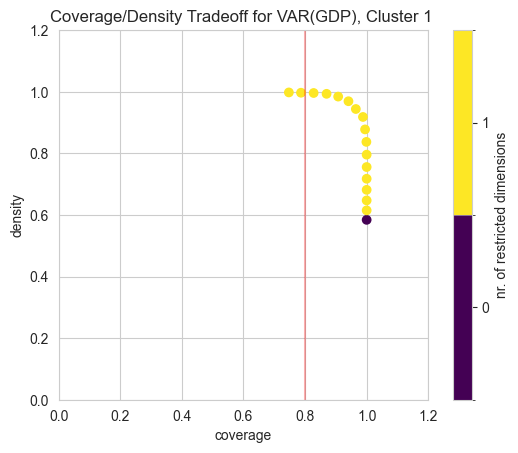

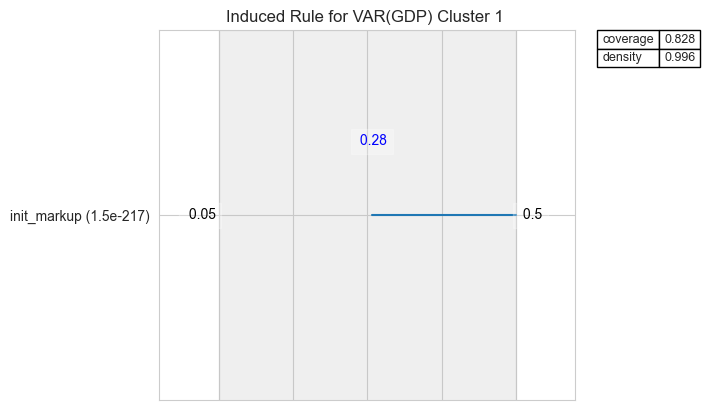

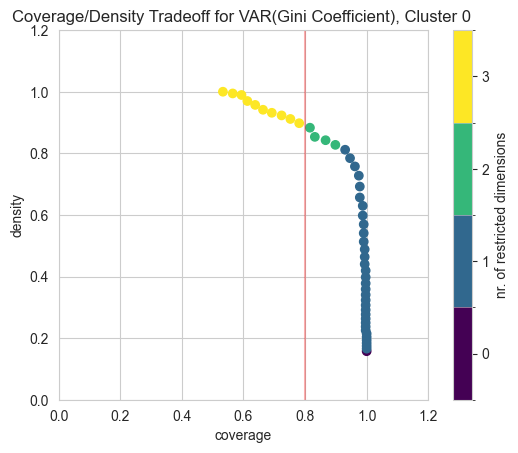

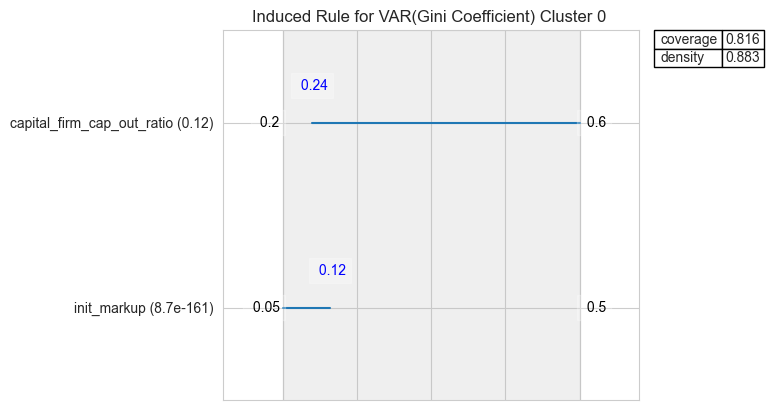

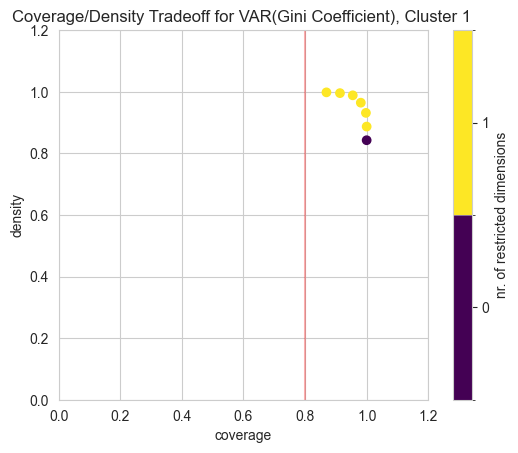

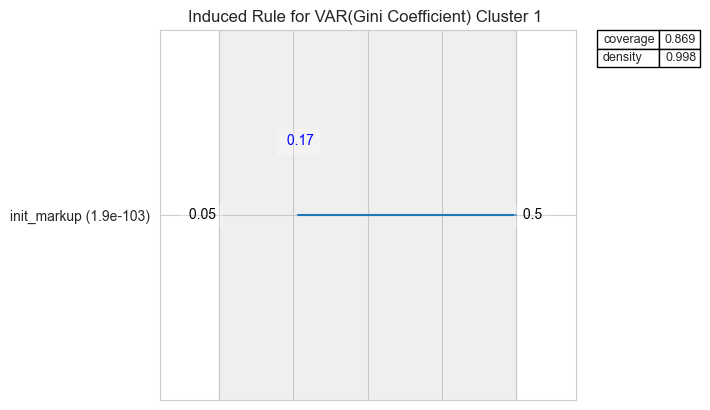

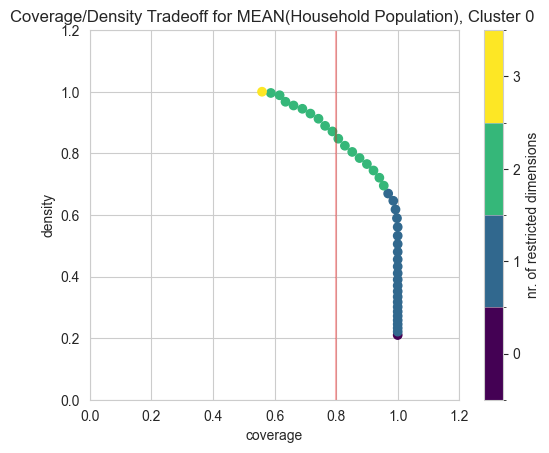

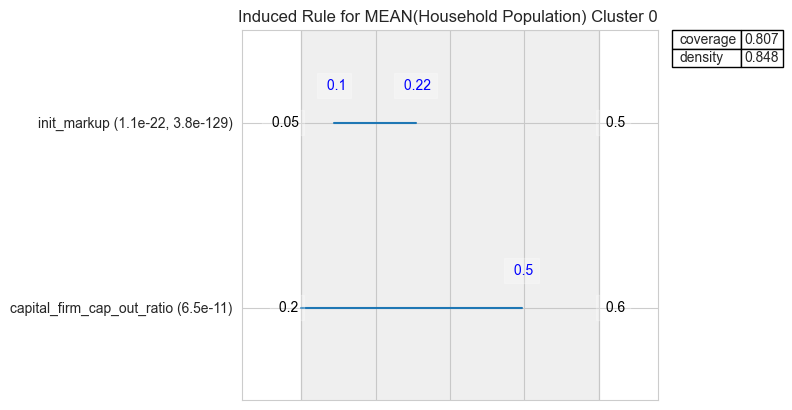

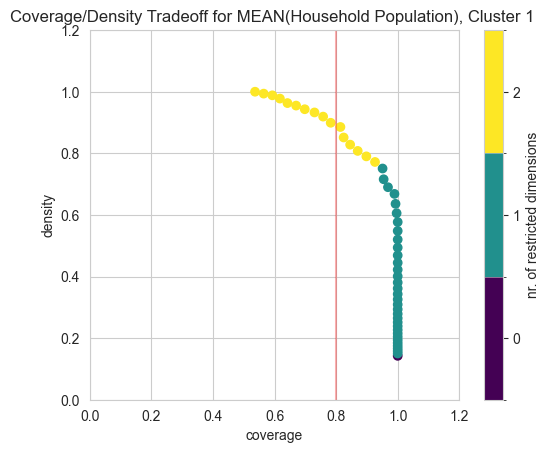

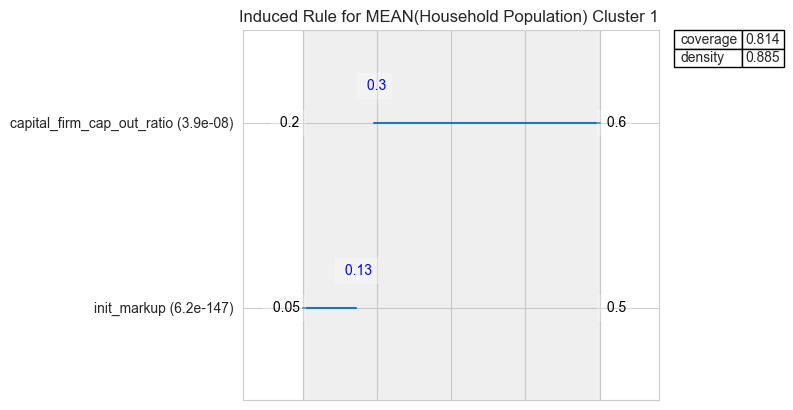

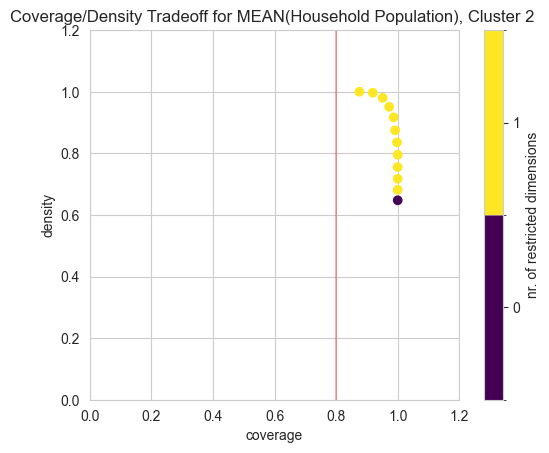

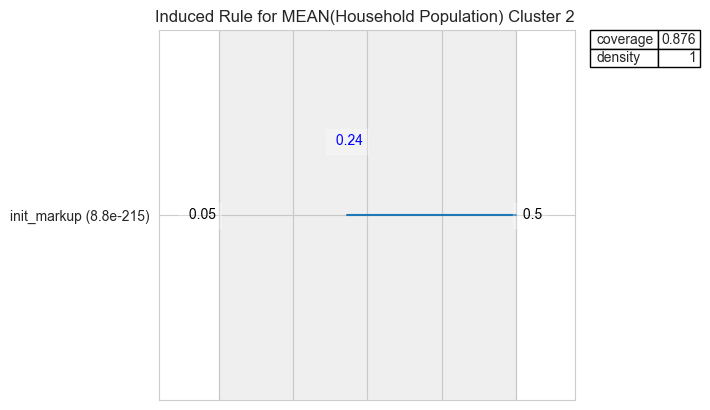

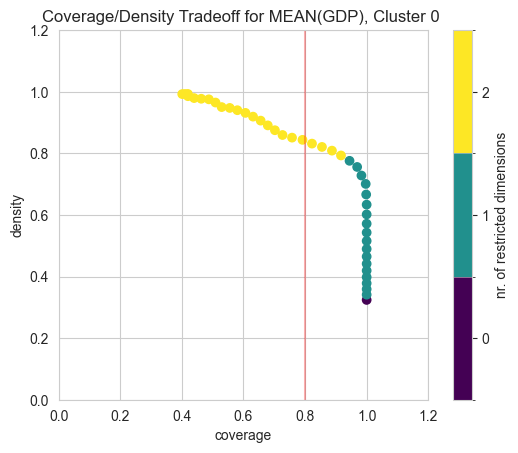

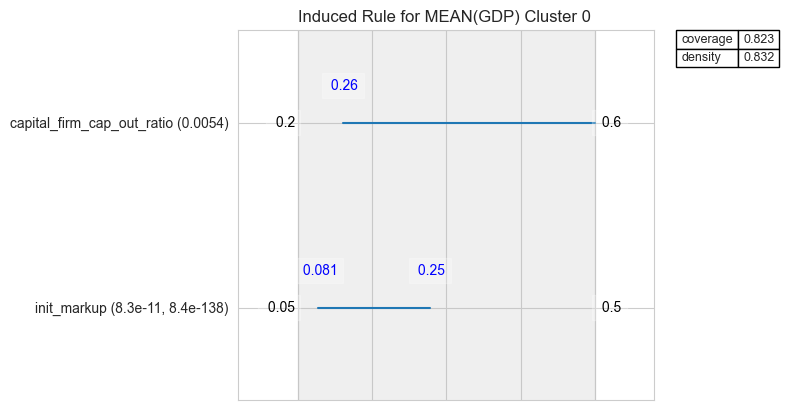

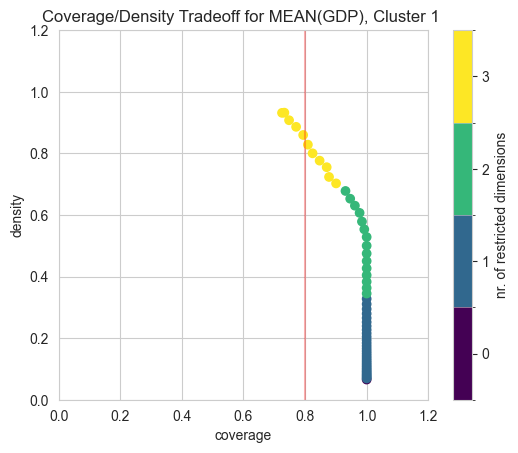

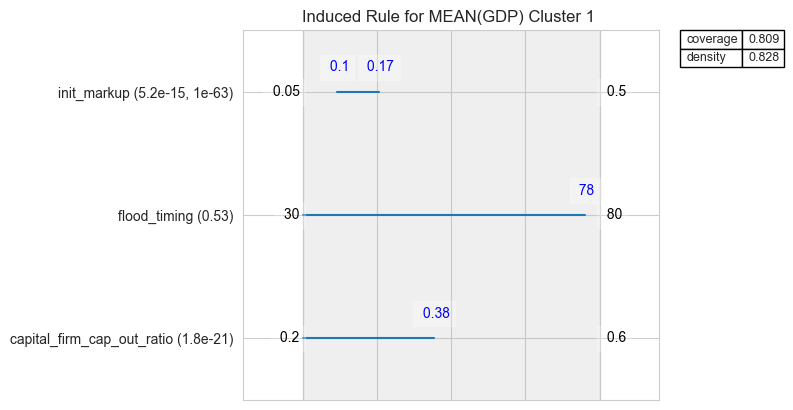

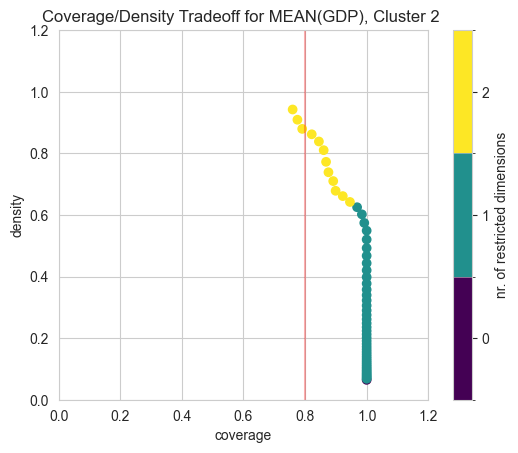

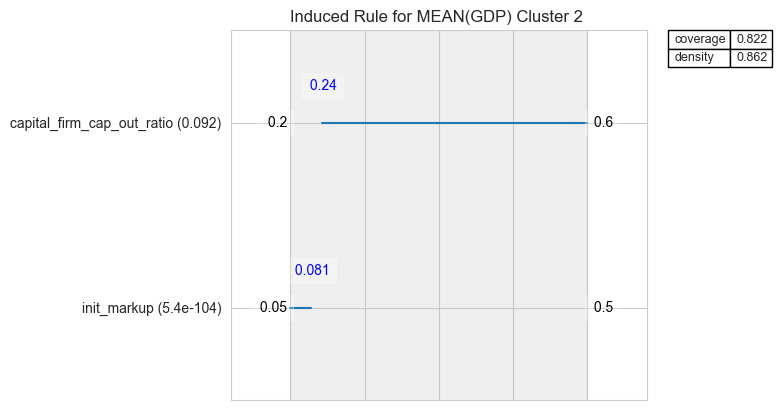

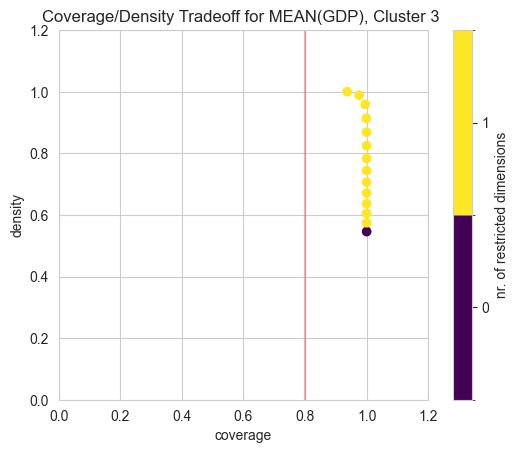

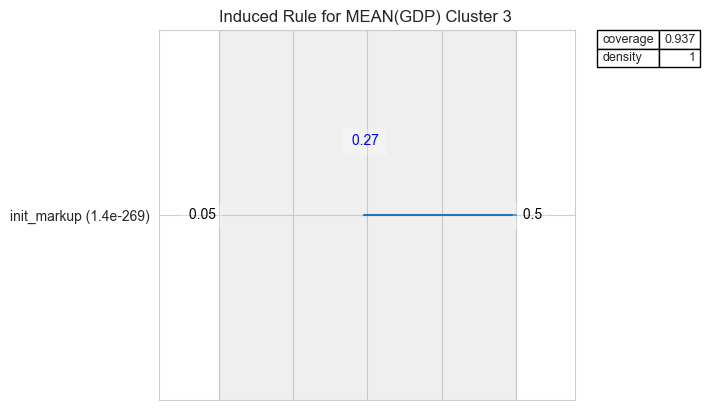

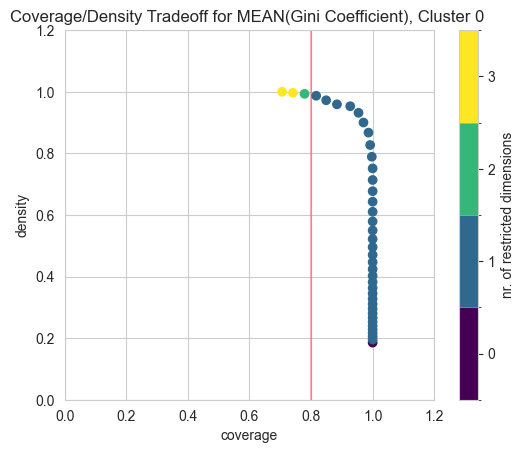

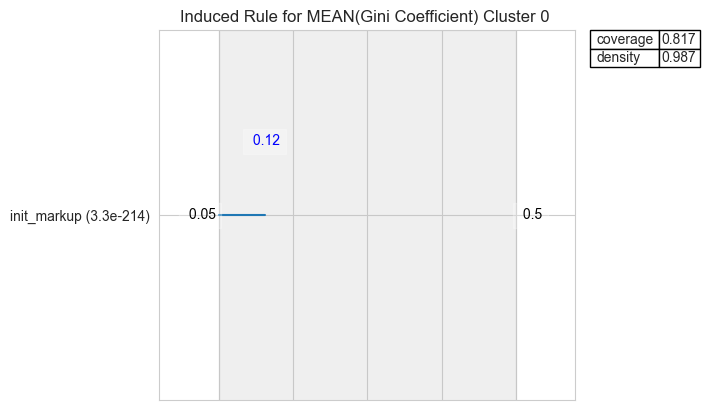

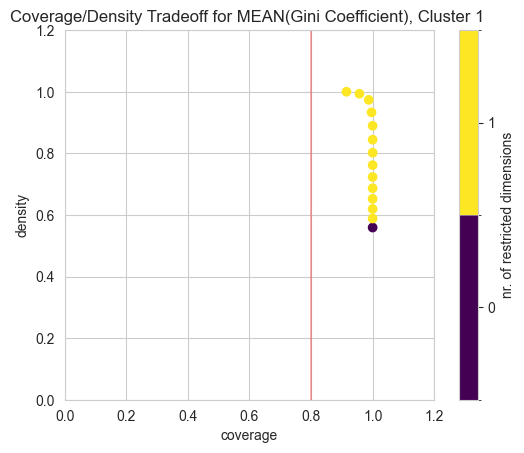

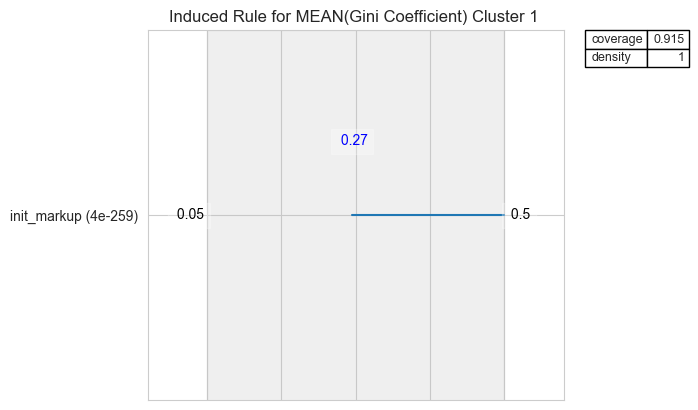

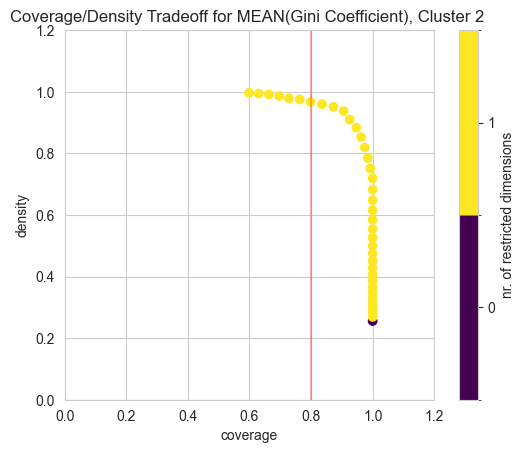

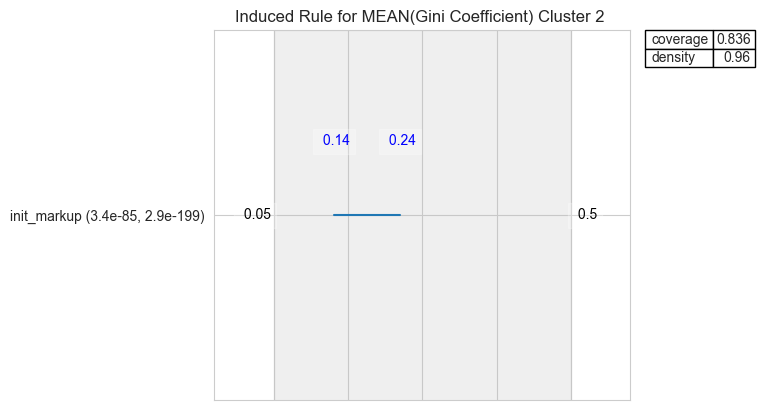

In [22]:
for key, box in prim_boxes.items():
    # Don't produce plot if no good results
    if len(box.peeling_trajectory) <= 1:
        print(f'Could not find suitable boxes for {key} using density_threshold={density_threshold}')
        continue

    # Extract information from key name
    # NORMAL OUTCOMES
    # var_name = key[0].split('(')[1][:-1]
    # cluster = key[1]
    # STOCHASTICITY OUTCOMES
    var_name = key[0].strip('Cluster (')[:-1] 
    cluster = key[1]
    
    # Visualize coverage/density trade-off
    box.show_tradeoff()
    # plt.hlines(y=[0.7], xmin=0, xmax=1.2, colors='k', alpha=0.3)
    plt.vlines(x=[0.8], ymin=0, ymax=1.2, colors='r', alpha=0.3)
    plt.title(f'Coverage/Density Tradeoff for {var_name}, Cluster {cluster} ')
    # plt.savefig('img/scenario_discovery__prim_trajectory.png')
    plt.show()

    # Select specific box (densest box with coverage > 0.8)
    acceptable_boxes = box.peeling_trajectory[(box.peeling_trajectory.coverage > 0.8)] # & 
                                            #   (box.peeling_trajectory.density > 0.7)]
    if len(acceptable_boxes) < 1:
        print(f'Could not find box with coverage > 0.8 for {var_name}, Cluster {cluster}')
        continue
    best_box = acceptable_boxes.index[-1]
    box.select(int(best_box))

    # Plot details of box
    box.inspect(style='graph')
    plt.title(f'Induced Rule for {var_name} Cluster {cluster} ')
    plt.show()